# Experiments with Ratio Outcomes

*A short introduction to the delta method*.

Some of the most common outcome metrics or **key performance indicators (KPI)** in the industry are **ratios**: click-through rates (clicks over views), returns on investment (revenue over cost), relative improvements (new value over old value), just to name few. If you want to investigate the causal effect of a treatment of interest (new product, new feature, new interface, ...) on these outcomes, the gold standard are randomized control trials, a.k.a. **AB tests**. Randomly assigning the treatment to a subset of the population (users, patients, customers, ...) we ensure that, on average, the only difference in outcomes can be attributed to the treatment. However, when the outcome is a ratio of two metrics, AB tests present some additional problems.

There are two main problems with estimating ratios, both stemming from the fact that we are not separately analyzing two causal quantities, but jointly. The first problem is that the estimator is biased. Even though, thanks to randomization, we can have unbiased estimates of the effect on page views and clicks, the estimate of the their ratio is biased. Second, computing a conference interval is not trivial.

In this post we are going to see how to solve both problems. First, we are going to apply a bias correction to the estimate. Second, we are going to explore a very powerful tool for inference with complex metrics: the **delta method**. While the algebra can be intense, the result is simple: we can compute the confidence interval for our ratio estimator using a simple linear regression. 

## Clicks and Ads

To better illustrate the concepts, we are going to use a toy example throughout the article. Support we were a **food delivery** company that is testing a new UI for their landing page. The object of interest is the **incremental click-through ratio**: does the number of clicks per view increase?

$$
\text{incremental ctr} = \frac{\text{incremental number of clicks}}{\text{incremental number of views}}
$$

Differently from usual AB tests or randomized experiments, we are not interested in a single metric, but in the **ratio** of two metrics, page views and orders. We will still use a **randomized control trial** or **AB test** to estimate the incremental CTR: randomly assign users to either a treatment control condition. The treated users will see the new landing page, while the control users will see the old one. Randomization ensures that we can estimate the impact of the new landing page on either clicks or views by comparing users in the treatment and control group: the difference in their average is an unbiased estimator of the average treatment effect. However, things are more complicated for their ratio.

I import the data generating process `dgp_loyalty()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py). I also import some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py).  To include not only code but also data and tables, I use [Deepnote](https://deepnote.com), a Jupyter-like web-based collaborative notebook environment. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from src.utils import *

In [2]:
from dataclasses import dataclass
from joblib import Parallel, delayed

class DGP:
    
    def __init__(self, n: int = 100, p: float = 0.5):
        self.n = n
        self.p = p
        self.df = self.generate_baseline_data() 
    
    def generate_baseline_data(self, seed: int = 0) -> pd.DataFrame:
        return pd.DataFrame()
    
    def add_assignment(self, df: pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        np.random.seed(seed)
        df['treatment'] = np.random.binomial(1, self.p, self.n)
        return df
    
    def add_treatment(self, df: pd.DataFrame) -> pd.DataFrame:
        return pd.DataFrame()
    
    def generate_data(self, seed_data: int = 0, seed_assignment: int = 0) -> pd.DataFrame:
        df = self.df.copy() if seed_data==-1 else self.generate_baseline_data(seed_data)
        df = self.add_assignment(df, seed_assignment)
        df = self.add_treatment(df)
        return df
    
    def bootstrap_assignment(self, f, K):
        results = Parallel(n_jobs=8)(delayed(f)(self.generate_data(seed_assignment=i)) for i in range(K))
        return results
    
    def bootstrap_data(self, f, K):
        results = Parallel(n_jobs=8)(delayed(f)(self.generate_data(seed_data=i, seed_assignment=i)) for i in range(K))
        return results

In [30]:
class dgp_clicks(DGP):
    """Data Generating Process: clicks and views."""
    
    def generate_baseline_data(self, seed: int = 0):
        np.random.seed(seed)
        u = np.random.uniform(0, 3, self.n)
        views = 1 + np.random.exponential(u + 5)
        clicks = np.random.exponential(u / 2)
        df = pd.DataFrame({'views': views.copy(), 'clicks': clicks.copy()})
        return df
    
    def add_treatment(self, df):
        df['views'] = (df['views'] + 1*df['treatment'])//1
        df['clicks'] = (df['clicks'] + 0.1*df['treatment'])//1
        return df

In [31]:
dgp = dgp_clicks(n=10_000)
df = dgp.generate_data(seed_assignment=3)
df.head()

,views,clicks,treatment
0,11.0,0.0,1
1,3.0,0.0,1
2,4.0,2.0,0
3,2.0,0.0,1
4,2.0,1.0,1


The data contains information on the number of page `views` and `clicks` for a set of $10.000$ users over a period of a month. We also have information on the `treatment`: the new landing page.  As it often happens with business metrics, both distributions of views and clicks are very **skewed**.

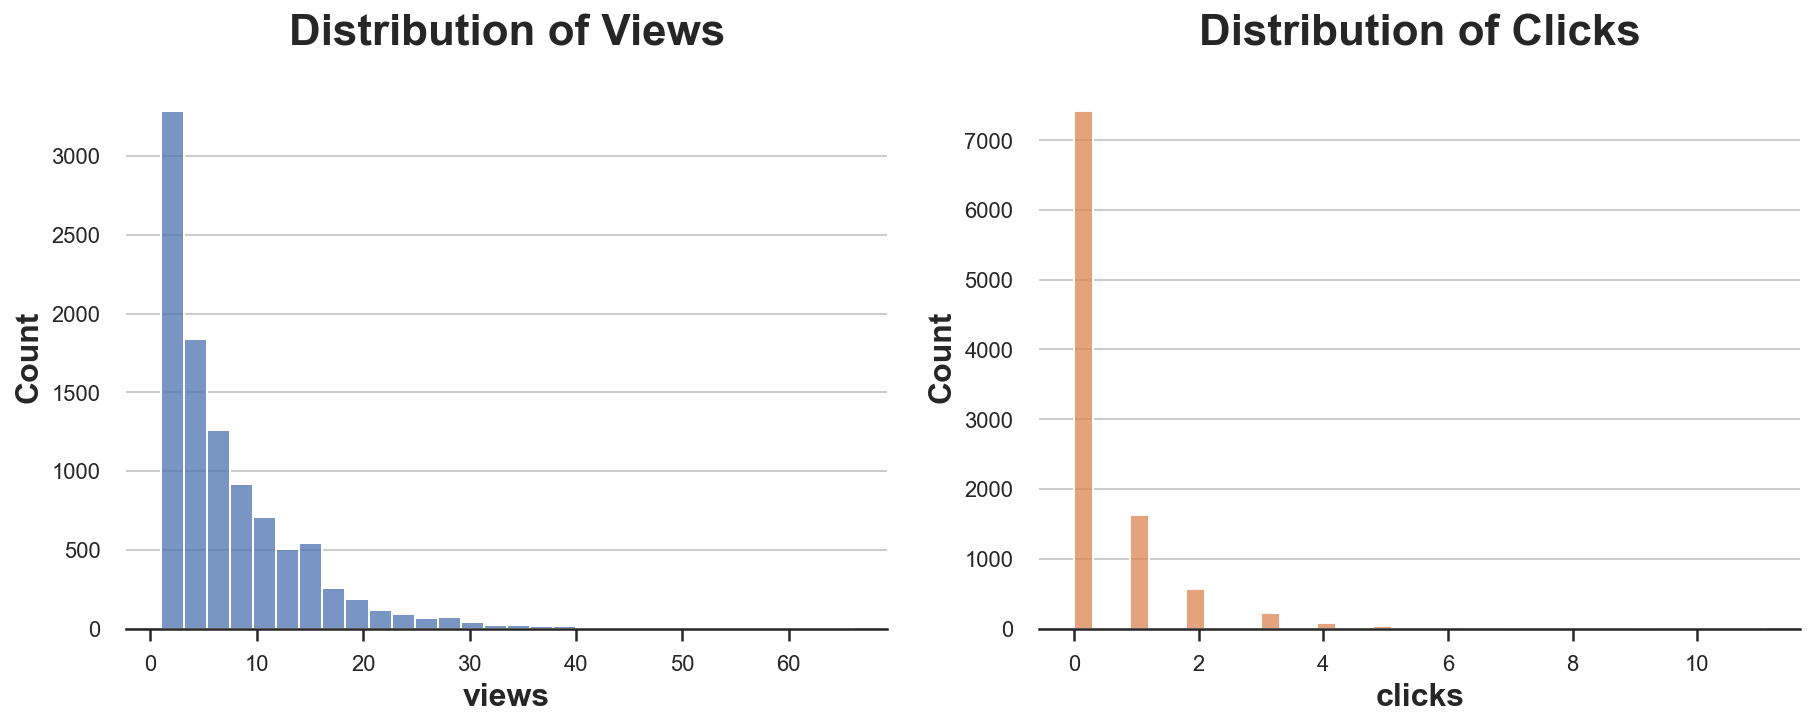

In [32]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df.views, ax=ax1, color='C0', bins=30).set(title='Distribution of Views')
sns.histplot(df.clicks, ax=ax2, color='C1', binwidth=.3).set(title='Distribution of Clicks');

We can compute the difference-in-means estimate by regressing the outcome on the treatment indicator.

In [33]:
smf.ols('views ~ treatment', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0833,0.093,76.533,0.000,6.902,7.265
treatment,0.7408,0.132,5.624,0.000,0.483,0.999


The number of views has increased by ???. What about clicks?

In [34]:
smf.ols('clicks ~ treatment', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3998,0.013,30.843,0.000,0.374,0.425
treatment,0.0519,0.018,2.815,0.005,0.016,0.088


Also the number of clicks has increased, by ???. What about their ratio?

We can estimate the incremental click-through rate as the ratio of the two previous estimates: the difference between the average clicks in the treatment minus control group, over the difference between the average views in the treatment minus control group.

$$
\overline{\text{ctr}} = \frac{\Delta C}{\Delta V}
$$

, where $\Delta$ indicates the treatment-control average difference.

In [35]:
def estimate_ctr(df):
    clicks = df.loc[df.treatment==1, "clicks"].mean() - df.loc[df.treatment==0, "clicks"].mean()
    views = df.loc[df.treatment==1, "views"].mean() - df.loc[df.treatment==0, "views"].mean()
    return clicks / views

In [36]:
estimate_ctr(df)

0.07009432424234391

The estimate is $0.07$: for each additional page view, we observe 7% of clicks. How much should we trust this number? Is it significantly different form zero, or it is just driven by noise?

To answer this question, we would like to compute a [**confidence interval**](https://en.wikipedia.org/wiki/Confidence_interval). How do we compute a a confidence interval for a ratio metric? The first step is to compute the standard deviation of the estimator. 

One method that is always available is the [**bootstrap**](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)): resample the data with replacement multiple and times and use the distribution of the estimates over samples to compute the standard deviation of the estimator.

Let's try it in our case. I compute the standard deviation over $10.000$ bootstrapped samples, using the function `pd.DataFrame().sample()` to sample with replacement.

In [37]:
np.std([estimate_ctr(df.sample(frac=1, replace=True, random_state=i)) for i in range(10_000)])

0.029349926403892786

The bootstrap estimate of the standard deviation is equal to $0.0293$. How good is it?

Since we fully control the data generating process, we can simulate the "true" distribution of the estimator. We do that for $10.000$ simulations and we compute the resulting standard deviation of the estimator.

In [38]:
np.std(dgp.bootstrap_assignment(estimate_ctr, 10_000))

0.01966553444052361

The "true" variance of the estimator seems to be lower, around $0.0197$. The issue might be related to the fact that the bootstrap is particularly volatile with skewed distributions. One solution is the [**bayesian boostrap**](https://medium.com/towards-data-science/the-bayesian-bootstrap-6ca4a1d45148) that I have covered in a separate post.

We are now going to explore another *extremely* powerful alternative, the [**delta method**](https://en.wikipedia.org/wiki/Delta_method). The delta method generally allows us to do inference on functions of random variable, therefore it's applications are broader than ratios. However, I don't think there is an easy way to approach the delta method, so the next section is going to be algebra-intense. If you want, you can skip it and go straight to the last section.

## The Delta Method

What is the **Delta Method**? In short, it is an incredibly powerful **asymptotic inference** method for functions of random variables, that exploits Taylor expansions. In short, the Delta Method requires four ingredients

- One or more [random variables](https://en.wikipedia.org/wiki/Random_variable)
- A function
- [The Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)
- [Taylor expansions](https://en.wikipedia.org/wiki/Taylor_series)

I will assume some basic knowledge of all four concepts. Suppose we had a set of realizations $X_1$, ..., $X_n$ of a random variable that satisfy the requirements for the Central Limit Theorem (CLT): independence, identically distributed with mena $\mu$ and finite variance $\sigma$. Under these conditions, the CLT tells us that the distribution of the sample average $\bar X$ converges in distribution to a normal distribution, or more precisely

$$
\sqrt{n} \ \frac{ \bar X - \mu}{\sigma} \ \overset{D}{\to} \ N(0, 1)
$$

, where $\mu$ is the average of $X$ and $\sigma$ is its standard deviation. What does the equation mean? It reads "the normalized sample average, scaled by a factor $\sqrt{n}$, converges in distribution to a standard normal distribution, i.e. it is approximately Gaussian for a sufficiently large sample.

Now, suppose we were interested in a **function** of the sample average $f(\bar X)$ instead of the sample average $\bar X$. Note that this is different from the average of the function $\overline{f(X)}$. The Delta Method tells us what the function of the sample average $f(\bar X)$ converges in distribution to. 

$$
\sqrt{n} \ \frac{ \bar X - f(\mu)}{\sigma} \ \overset{D}{\to} \ N \big(0, f'(\mu)^2 \big)
$$

, where $f'(\mu)^2$ is the derivative of the function $f$, evaluated at $\mu$.

The result directly follows from the Taylor approximation of $f(\bar X)$

$$
f(\bar X) = f(\mu) + f'(\mu) (\bar X - \mu) + O \big\lbrace (\bar X - \mu)^2 \big\rbrace
$$

Importantly, asymptotically, the last term disappears and the linear approximation holds exactly!

How is this connected to the ratio estimator? We need a bit more math and to switch from a single dimension to two dimensions in order to understand that. In our case, we have a bivariate function that input two random variables, $\Delta C$ and $\delta V$ and returns their ratio. In the case of a multivariate function $f$, the asymptotic variance of the estimator is given by

$$
\text{AVar} f(\bar X) = \nabla f(\bar X)' \Sigma \nabla f(\bar X)
$$

where, $\nabla$ indicates the [gradient](https://en.wikipedia.org/wiki/Gradient) of the function, i.e. the vector of directional derivatives, and $\Sigma$ is the variance-covariance matrix of $X$. In our case, they correspond to

$$
\begin{align*}
\nabla f(\bar X) = 
\begin{bmatrix} 
f_{\Delta V} (\bar X) \\ f_{\Delta C} (\bar X)
\end{bmatrix} 
= 
\begin{bmatrix} 
\frac{1}{\mathbb E [\Delta V]} \\ - \frac{\mathbb E [\Delta C]}{\mathbb E [\Delta V]^2}
\end{bmatrix}
\end{align*}
$$

and

$$
\begin{align*}
\Sigma = 
\begin{bmatrix}
\text{Var} (\Delta C) & \text{Cov} (\Delta C, \Delta V) \\
\text{Cov} (\Delta C, \Delta V) & \text{Var} (\Delta V) \\
\end{bmatrix}
\end{align*}
$$

With a little matrix algebra, we get the formula of the asymptotic variance of the ratio estimator.

$$
\begin{align*}
\text{AVar} \left( \frac{\Delta C}{\Delta V} \right) &= \frac{1}{\mathbb E[\Delta V]^2} \text{Var}(\Delta C) - 2 \frac{\mathbb E[\Delta C]}{\mathbb E[\Delta V]^3} \text{Cov}(\Delta V, \Delta C) + \frac{\mathbb E[\Delta C]^2}{\mathbb E[\Delta V]^4} \text{Var}(\Delta V)
\end{align*}
$$

Importantly, we can rewrite the variance noting that the estimator is given by $\hat \lambda = \frac{\mathbb E[\Delta C]}{\mathbb E[\Delta V]}$

$$
\begin{align*}
\text{Var} \left( \frac{\Delta C}{\Delta V} \right) = \frac{1}{\mathbb E[\Delta V]^2} \text{Var} \Big( \Delta C - \hat \lambda \Delta V \Big) = \frac{1}{\mathbb E[\Delta V]^2} \text{Var} \Big( \Delta \big( C - \hat \lambda V \big) \Big)
\end{align*}
$$

The last expression is very interesting because it suggests that we can estimate the standard deviation of our estimator by **linear regression**.

## Inference with Linear Regression

Did you skip the previous section? No problem! (and good choice)

We just realized that we can estimate the variance of our estimator as

$$
\begin{align*}
\text{Var} \left( \frac{\Delta C}{\Delta V} \right) = \frac{1}{\mathbb E[\Delta V]^2} \text{Var} \big( \Delta \tilde C \big)
\end{align*}
$$

, where $\tilde C = C - \hat \lambda V$. This expression might seem very obscure to you, but it's extremely practical. Let's go through it step by step

1. The term $\mathbb E[\Delta V]$ is just the difference in average clicks between treatment and control group

In [39]:
e_delta_v = df.views[df.treatment==1].mean() - df.views[df.treatment==0].mean()

2. The variable $\tilde C$ is easier to compute: we just need to subtract from the clicks $C$ the number of views $V$, times the estimated click-through rate $\hat \lambda$.

In [40]:
df['clicks_tilde'] = df['clicks'] - estimate_ctr(df) * df['views'] 

3. The variance of the treatment-control difference $\Delta \tilde C$ can be directly computed by linear regression, as we always do in randomized controlled trials.

In [41]:
sd_err = smf.ols('clicks_tilde ~ treatment', df).fit().bse[1]

We now have all the ingredients to compute the standard deviation of the estimator..

In [42]:
sd_err / np.abs(e_delta_v)

0.027268564428518813

We have estimated the variance of the ratio estimator with a simple linear regression! The estimated value $0.0273$ is quite close to the one we estimated with bootstrap. 

How accurate is it on average? Since we control the data generating process, we can compute the average estimated variance over $10.000$ simulations.

In [43]:
np.mean(dgp.bootstrap_assignment(compute_variance, 10_000))

NameError: name 'compute_variance' is not defined

The value is $0.0196$, basically identical to the previously computed one.

## Conclusion

### References

[1] A. Deng, U. Knoblich, J. Lu, [Applying the Delta Method in Metric Analytics: A Practical Guide with Novel Ideas](https://arxiv.org/pdf/1803.06336.pdf) (2018).  

[2] [Consistent Transformation of Ratio Metrics for Efficient Online Controlled Experiments](https://dl.acm.org/doi/abs/10.1145/3159652.3159699) (2018). *ACM*.

### Related Articles

- [The Bayesian Bootstrap](https://medium.com/towards-data-science/the-bayesian-bootstrap-6ca4a1d45148)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/delta.ipynb